## Goal : check shear SNR prediction vs CLMM mock data

In [2]:
import os
os.environ['CLMM_MODELING_BACKEND'] = 'ccl' # here you may choose ccl, nc (NumCosmo) or ct (cluster_toolkit)


import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from astropy.io import ascii
from scipy.optimize import curve_fit
from scipy.integrate import quad
from scipy import stats, interpolate

import sys
sys.path.append('../../')
import magnification_library as magnification_library
from magnification_library import *

import clmm
import clmm.support.mock_data as mock
import pyccl

from importlib import reload  
import pandas as pd

In [3]:
clmm.__version__

'1.0.0'

In [4]:
reload(magnification_library)

<module 'magnification_library' from '../../magnification_library.py'>

In [5]:
#define cosmology

#astropy object
cosmo = FlatLambdaCDM(H0=71, Om0=0.265, Tcmb0=0 , Neff=3.04, m_nu=None, Ob0=0.0448)

#ccl object
cosmo_ccl = pyccl.Cosmology(Omega_c=cosmo.Om0-cosmo.Ob0, Omega_b=cosmo.Ob0,
                      h=cosmo.h, sigma8= 0.80, n_s=0.963)
#clmm object
cosmo_clmm = clmm.Cosmology(be_cosmo=cosmo_ccl)

In [9]:
path_file = '../../../'

In [10]:
#computation utils properties
z_s = np.linspace(0.001, 4, 1000)
zinf = 1000 


In [11]:
key = 'LBGp'
quant = np.load(path_file + "output_data/binned_correleation_fct_Mpc_"+key+".npy", allow_pickle=True)

In [12]:

gal_cat_raw =  pd.read_hdf(path_file+'input_data/cat_'+key+'.h5', key=key)
dat = np.load(path_file+"input_data/source_sample_properties.npy", allow_pickle=True)
mag_cut, alpha_cut, mag_null, gal_dens, zmean = dat[np.where(dat[:,0]==key)][0][1:]

print (alpha_cut)
mag_cut

3.320964657712193


25.495

In [13]:
selection_source = (gal_cat_raw['ra']>50) & (gal_cat_raw['ra']<73.1) & (gal_cat_raw['dec']<-27.) & (gal_cat_raw['dec']>-45.)
selection = selection_source & (gal_cat_raw['mag_i_lsst']<mag_cut) & (gal_cat_raw['redshift']>1.5)

gal_cat = gal_cat_raw[selection]

### Source / lens properties

In [14]:
#Source galaxies properties 
#(source shear shot noise or LF slope, source density, redshift distribution parametrization)


#MAGNIFICATION LSST u-dropout_________________________________________________________
#see Fig 6 in https://arxiv.org/pdf/1904.13378.pdf for u-dropout

#At z~3 the LSST band corresponding to UV ~ 1500 Angstrom is the r band.
#limiting mag from C1 in https://arxiv.org/pdf/1809.01669.pdf
mlim = 25.495 #i band

alpha_lbg = 3.321

n_eff_lbg = 0.54/(u.arcmin*u.arcmin)

def mu_lbg_pdz(z):
    func = gaussian(z, 1, 2.6, 0.61/(2*np.sqrt(2*np.log(2))))
    return func/quad(lambda z: gaussian(z, 1, 2.6,0.61/(2*np.sqrt(2*np.log(2)))), 0, np.inf)[0]

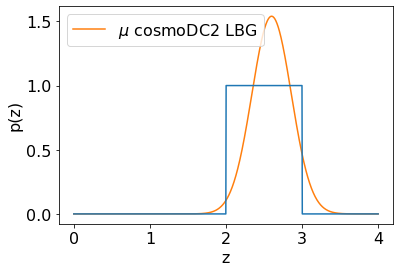

In [15]:
plt.plot(z_s, mu_lbg_pdz(z_s), 'C1',  label = '$\mu$ cosmoDC2 LBG')

plt.plot(z_s, np.heaviside(z_s-2,0)* np.heaviside(3-z_s,0))

plt.xlabel('z')
plt.ylabel("p(z)")
plt.legend();

Text(0, 0.5, 'pdf')

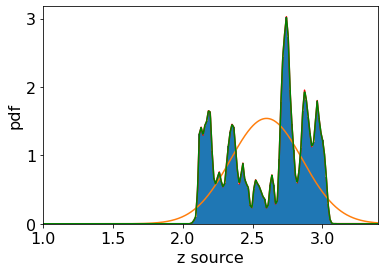

In [16]:
hist = plt.hist(gal_cat['redshift'][selection], bins=100, range=[1.8,3.1], density=True, stacked=True);
pdf_zsource = zpdf_from_hist(hist, zmin=0, zmax=10)

plt.plot(pdf_zsource.x, pdf_zsource.y, 'r')
plt.xlim(1,3.4)

plt.plot(z_s, mu_lbg_pdz(z_s), 'C1',  label = '$\mu$ cosmoDC2 LBG')

plt.plot(z_s, np.heaviside(z_s-2,0)* np.heaviside(3.1-z_s,0) * pdf_zsource(z_s),'g')

plt.xlabel('z source')
plt.ylabel('pdf')

In [17]:
def get_halo_concentration(mass_lens, z_lens, cosmo_ccl, relation="Diemer15", mdef="matter", delta_so=200):
    mdef = pyccl.halos.massdef.MassDef(delta_so, mdef, c_m_relation=relation)
    concdef = pyccl.halos.concentration.concentration_from_name(relation)()
    conc = concdef.get_concentration(cosmo=cosmo_clmm.be_cosmo, M=mass_lens, a=cosmo_clmm.get_a_from_z(z=z_lens), mdef_other=mdef)
    return conc 

In [18]:
#Lens properties


[z_cl, mass_cl, n_halo] = np.load(path_file + "output_data/halo_bin_properties.npy", allow_pickle=True)
Delta_SO = 200
#concentration = get_halo_concentration(mass_cl, z_cl, cosmo_clmm.be_cosmo, "Diemer15", "matter", Delta_SO )

## - Model construction

In [19]:
radial_unit, rmin, rmax, nbins, method = 'Mpc', 0.1, 7, 10, 'evenlog10width'
binedges = clmm.utils.make_bins(rmin, rmax, nbins=nbins, method=method)

In [20]:
dict_profile = {'density contrast conv.': \
                {'model_func':  clmm.theory.compute_convergence, \
                'noise_func': noise_mag,\
                'model_arg': 2 * abs(alpha_lbg-1), \
                'source_pdz': mu_lbg_pdz,\
                'source_density': n_eff_lbg,\
                'delta_z_cut' : 0.1},
                'density contrast': \
                {'model_func':  clmm.theory.compute_magnification, \
                'noise_func': noise_mag,\
                'model_arg': alpha_lbg, \
                'source_pdz': pdf_zsource ,\
                'source_density': n_eff_lbg,\
                'delta_z_cut' : 0.1}}


In [21]:
profile_type = "density contrast"

In [22]:
bin_center, bin_edges, noise, model, Ngal = np.zeros((5, 5, 5), dtype=object)

for i in range(z_cl.shape[0]):
    for j in range(z_cl.shape[1]):
        concentration = get_halo_concentration(mass_cl[i,j], z_cl[i,j], cosmo_clmm.be_cosmo, "Diemer15", "matter", Delta_SO )
        bin_center[i,j], bin_edges[i,j], noise[i,j], model[i,j] = profile_determination(rmin, rmax, radial_unit , z_cl[i,j], mass_cl[i,j] , profile_type , dict_profile, cosmo_clmm, nbins, method=method, conc=concentration, delta_mdef=200, zinf=zinf)
        bin_center[i,j], bin_edges[i,j], Ngal[i,j] = compute_source_number_per_bin(rmin, rmax, radial_unit, z_cl[i,j], dict_profile[profile_type]['source_pdz'], dict_profile[profile_type]['source_density'], nbins, method, cosmo_clmm)

## - Noise contribution from the profile construction

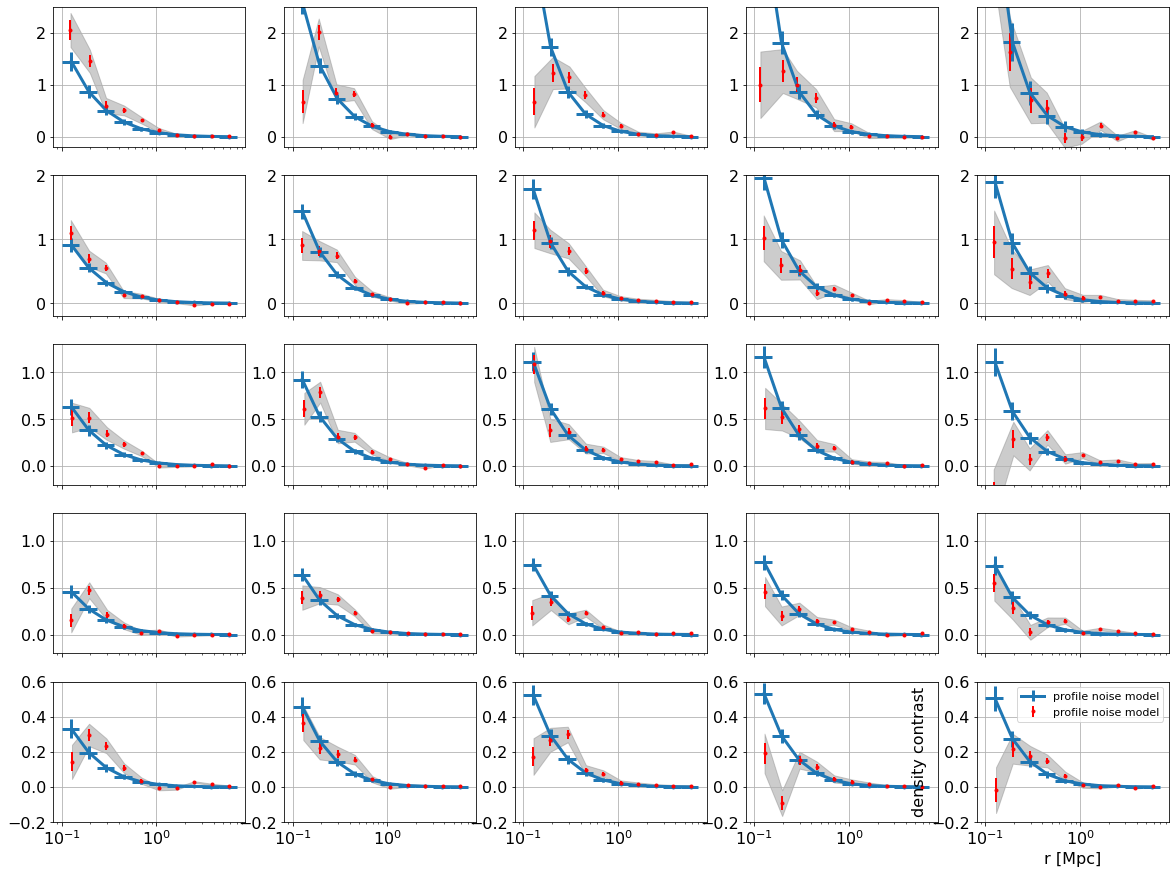

In [23]:
i,j = 0,0


fig, axes = plt.subplots(5,5, figsize=[20,15], sharex=True)


for i,h in zip([0,1,2,3,4],range(5)):
    for j,k in zip([0,1,2,3,4],range(5)):
        
        ax = axes[5-1-k,h]
        
        ax.errorbar(bin_center[i,j], model[i,j], xerr = [bin_center[i,j] - bin_edges[i,j][0:-1], bin_edges[i,j][1:] - bin_center[i,j]],\
             fmt='.-', lw=3, label='profile noise model', yerr = noise[i,j]/np.sqrt(n_halo[i,j]))

        ax.fill_between(quant[i,j][0], y1= quant[i,j][1] - np.sqrt(np.diag(quant[i,j][2])),\
                 y2 =  quant[i,j][1]  + np.sqrt(np.diag(quant[i,j][2])),color = 'grey', alpha=0.4)
        
        ax.errorbar(quant[i,j][0], quant[i,j][1], fmt='r.', lw=2, label='profile noise model', yerr = noise[i,j]/np.sqrt(n_halo[i,j]))
        

#plt.ylim(0)
        ax.grid()
    
axes[0,0].set_xscale('log')

plt.legend(fontsize='x-small')

plt.ylabel(profile_type)
plt.xlabel('r [' + radial_unit + ']');


for i in range(axes.shape[0]):
    axes[4,i].set_ylim(-0.2,0.6)
    axes[3,i].set_ylim(-0.2,1.3)
    axes[2,i].set_ylim(-0.2,1.3)
    axes[1,i].set_ylim(-0.2,2.0)
    axes[0,i].set_ylim(-0.2,2.5)

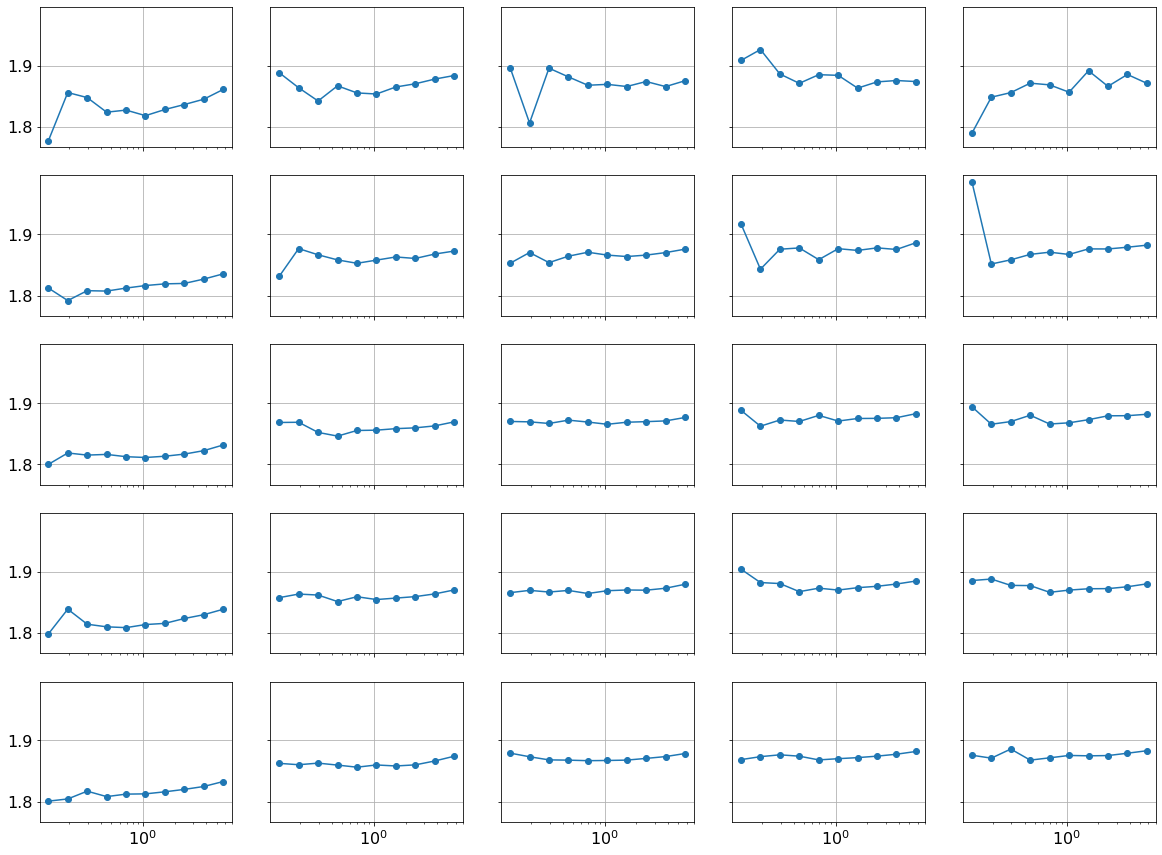

In [24]:
fig, axes = plt.subplots(5,5, figsize=[20,15], sharex=True, sharey=True)


for i,h in zip([0,1,2,3,4],range(5)):
    for j,k in zip([0,1,2,3,4],range(5)):
        
        ax = axes[5-1-k,h]

        ax.plot(bin_center[i,j], np.sqrt(np.diag(quant[i,j][2])) / (noise[i,j]/np.sqrt(n_halo[i,j])),'o-')
        
        ax.grid()
    
axes[0,0].set_xscale('log')

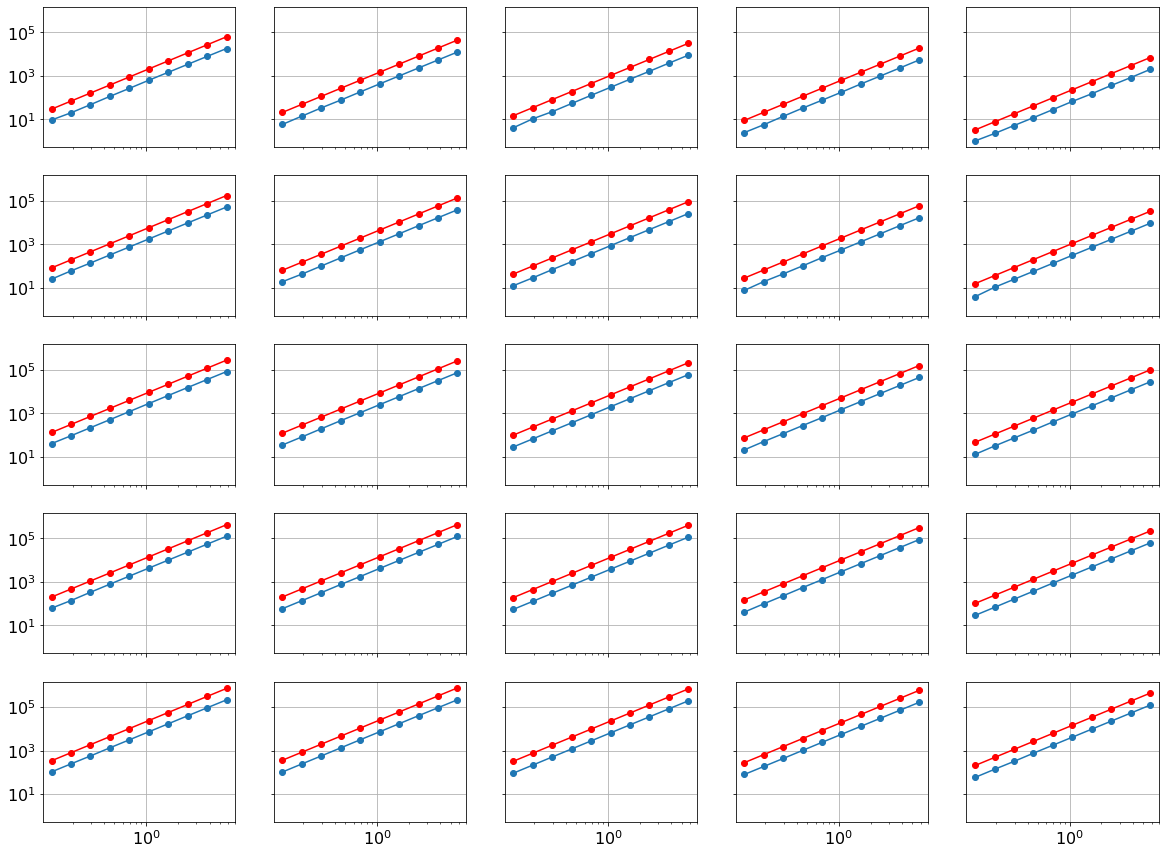

In [37]:
fig, axes = plt.subplots(5,5, figsize=[20,15], sharex=True, sharey=True)


for i,h in zip([0,1,2,3,4],range(5)):
    for j,k in zip([0,1,2,3,4],range(5)):
        
        ax = axes[5-1-k,h]

        ax.plot(bin_center[i,j], 1/(np.diag(quant[i,j][2])),'o-')
        ax.plot(bin_center[i,j],  (Ngal[i,j]*n_halo[i,j]),'ro-')
        
        ax.grid()
    
axes[0,0].set_xscale('log')
axes[0,0].set_yscale('log')